In [1]:
import glob
import re

import scipy.interpolate as interpolate
from matplotlib import pyplot as plt
import numpy as np

from utils import Graph

# Different pressure levels
P_v = [2, 7, 15]
N_v = [1.15e19, 4.02e19, 8.61e19]

def alpha(P,E,A,B):
    return P * A * np.exp(-B*P/E)

def reduced_alpha(x, A,B):
    return A * np.exp(-B/x)

def M(alpha,dx):
    return np.exp(alpha * dx)

def psi_to_torr(p):
    return p * 51.7149

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

The below imports and processes the simulation runs. At each bulk field, $20$ simulations were run for $1$ $\mu$s at the three investigated pressures.

In [2]:
E_vals = [[], [], []]

alpha_vals = [[], [], []]
M_vals = [[], [], []]

for i, p in enumerate(P_v):
    file_tree = {}
    
    for file in glob.glob(f'gar-townsend-coef/{p}/*.txt'):
        key = int(re.search(r'(\d*)(?:V)', file).group(1))
        if (key in file_tree):
            file_tree[key].append(file)
        else:
            file_tree[key] = [file]

    for key, value in sorted(file_tree.items()):
        group = Graph(value)
        
        E_vals[i].append(key)
        
        alpha_vals[i].append(group.alpha(recursive=False))
        M_vals[i].append(group.M(recursive=False))

The below plots the simulated Townsend coefficient. The theoretical curve is taken from Sauli, Fabio. Principles of operation of multiwire proportional and drift chambers. Lec- tures given in the Academic Training Programme of CERN 1975–1976, pages 1–92, May 1977.

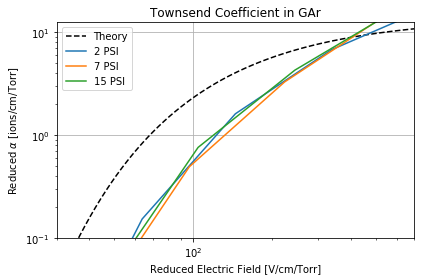

In [3]:
x_v = np.logspace(1, 3, 100)
alpha_red_v = reduced_alpha(x_v, 14, 180)

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

plt.plot(x_v, alpha_red_v, 'k--', label='Theory')

for i, p in enumerate(P_v):
    plt.plot([v / psi_to_torr(p) for v in E_vals[i]], [a / psi_to_torr(p) for a in alpha_vals[i]], label=f'{p} PSI')

plt.title(f'Townsend Coefficient in GAr')
plt.xlabel('Reduced Electric Field [V/cm/Torr]')
plt.ylabel('Reduced $\\alpha$ [ions/cm/Torr]')

plt.xlim(3e1, 7e2)
plt.ylim(1e-1, 1.25e1)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig(f'gar_townsend.pdf', bbox_inches='tight')

The below plots the simulated electron multiplication factor. The late onset and lack of saturation is directly inferable from the above plot of the Townsend coefficient.

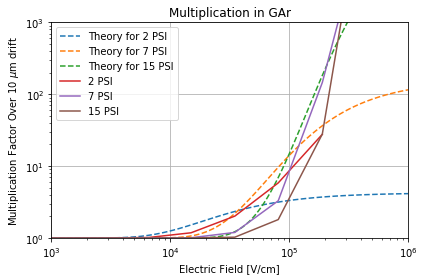

In [4]:
E_v = np.logspace(3, 6, 100)

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

for i, p in enumerate(P_v):
    a_v = alpha(psi_to_torr(p), E_v, 14, 180)
    mult_v = M(a_v, 10 * 1e-4)
    plt.plot(E_v, mult_v, ls='--', label=f'Theory for {p} PSI')

for i, p in enumerate(P_v):
    plt.plot(E_vals[i], M_vals[i], label=f'{p} PSI')

plt.xlabel('Electric Field [V/cm]')
plt.ylabel('Multiplication Factor Over 10 $\mu$m drift')
plt.title(f'Multiplication in GAr')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3, 1e6)
plt.ylim(1e0, 1e3)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig(f'gar_mult.pdf', bbox_inches='tight')